# Title 
## 4. Modeling

### Import statements and files

In [102]:
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt

In [2]:
hatemaps = pd.read_csv('/Users/gemma/Documents/data science/fc-hatemaps.csv')
crimes_by_state = pd.read_csv('/Users/gemma/Documents/data science/fc-crimes_by_state.csv')
state_totals = pd.read_csv('/Users/gemma/Documents/data science/fc-hate-state_totals.csv')
by_city_only = pd.read_csv('/Users/gemma/Documents/data science/fc-hate-by_city.csv')

### Feature engineering

First, some ideas of features that I had. Later, I'll use some unsupervised methods.

* Number of unique cities per state with at least 1 reported hate crime
* Max count of hate groups in any 1 city in each state
* Number of unique cities per state with at least 1 hate group
* Binary indicators of 5 largest hate groups presence in each city / state

In [3]:
# number of unique cities per state with at least 1 reported hate crime

state_totals = pd.merge(state_totals, 
                        by_city_only.groupby(['Year','State'])['Agency name'].nunique().reset_index().rename(index=str,
                            columns={'Agency name': 'Number of cities with 1+ hate crime'}), 
                        on=['Year','State'])

In [4]:
# max count of hate groups in 1 city in each state

state_totals = pd.merge(state_totals, hatemaps.groupby(['Year','State',
                  'City'])['Group Name'].count().groupby(['Year',
                 'State']).max().reset_index().rename(index=str,columns={'Group Name': 
                    'Largest num of hate groups in any 1 city'}),
                        on=['Year','State'])


In [5]:
# count of unique cities with 1 or more hate groups in each state per year

state_totals = pd.merge(state_totals, 
                        hatemaps.groupby(['Year',
                            'State'])['City'].nunique().reset_index().rename(index=str,
                            columns={'City': 'Number of cities with 1+ hate groups'}), 
                        on=['Year','State'])

In [6]:
# for the cumulatively largest 5 hate groups (by count) in each category, 
# binary indicators of whether or not they exist in each state

# first get the names of the hate groups
largest_five = []

for htype in hatemaps['Hate Type'].unique():

    templist = hatemaps[hatemaps['Hate Type'] == htype].groupby(['Group Name'])['Group Name'].count().sort_values(ascending=False).head(5).index.tolist()

    for gr_name in templist:
        # add it to the list of largest five
        largest_five.append(gr_name)
        # also add a column to the hatemaps
        hatemaps[gr_name] = 0


In [7]:
# then add the names to the dataframe

for i, name in enumerate(hatemaps['Group Name'].tolist()):
    if name in largest_five:
        hatemaps.loc[i, name] =1

In [8]:
# add them as features to the states table

state_totals = pd.merge(state_totals, 
                        hatemaps.groupby(['Year','State'])[largest_five].sum().reset_index(), 
                        on=['Year','State'])

In [9]:
# add them as features to the city table as well

by_city_only = pd.merge(by_city_only, hatemaps, how="outer",  
                        right_on=['Year','State','City'], 
         left_on=['Year','State', 'Agency name']).fillna(0)

## feature engineering with unsupervised learning

* NLP - topic extraction
* Autoencoders?? (neural networks)
* clusters with mean shift

Using NLP I'll analyze the names of the hategroups and design features that will then be added to the tables above.

* keyword extraction
* topics

In [10]:
import spacy
from sklearn.feature_extraction.text import TfidfVectorizer

import nltk
from nltk.corpus import stopwords
import string

import networkx as nx

from gensim.test.utils import datapath
from gensim.models.word2vec import Text8Corpus
from gensim.models.phrases import Phrases, Phraser

In [11]:
# get all of the hate group names

hgnames = hatemaps['Group Name'].tolist()

newlist = []

for word in hgnames:
    newlist.append(word.replace('the',''))

hgnames_string = ". ".join(hgnames)
newlist_string = ". ".join(newlist)

In [12]:
nlp = spacy.load('en')

# parse the names
hgp = nlp(newlist_string)

In [13]:
# Dividing the text into sentences and storing them as a list of strings.
sentences=[]
for span in hgp.sents:
    # go from the start to the end of each span, returning each token in the sentence
    # combine each token using join()
    sent = ''.join(hgp[i].string for i in range(span.start, span.end)).strip()
    sentences.append(sent)

# Creating the tf-idf matrix.
counter = TfidfVectorizer(lowercase=False, 
                          stop_words='english',
                          ngram_range=(1, 1), 
                          analyzer=u'word', 
                          max_df=.5, 
                          min_df=1,
                          max_features=None, 
                          vocabulary=None, 
                          binary=False)

#Applying the vectorizer
data_counts=counter.fit_transform(sentences)

In [14]:
stop = stopwords.words('english') + list(string.punctuation) + ["''", "``" , "--", "n't", "'ve", "'s"]


sentence_stream = [[i.lower() for i in nltk.word_tokenize(sent) if i.lower() not in stop]  for sent in sentences]
bigram = Phrases(sentence_stream, min_count=1, threshold=3, delimiter=b' ')
bigram_phraser = Phraser(bigram)
tokens_ = bigram_phraser[sentence_stream]

bigrams_t = tokens_

bigrams_o = [i for j in bigrams_t for i in j]
print(bigrams_o[:25])

['christian', 'american', 'knights', 'ku', 'klu', 'klan', 'church', 'national', 'knights', 'ku', 'klu', 'klan', 'confederate', 'white', 'knights', 'ku', 'klu', 'klan', 'east coast', 'knights', 'true invisible', 'empire', 'georgia knight', 'riders', 'ku']


In [15]:
# Removing stop words and punctuation, then getting a list of all unique words in the text
hgp_filt_2 = [word for word in bigrams_o if word not in stop]
words2=set(hgp_filt_2)

#Creating a grid indicating whether words are within 4 places of the target word
adjacency2=pd.DataFrame(columns=words2,index=words2,data=0)

#Iterating through each word in the text and indicating which of the unique words are its neighbors
for i,word in enumerate(bigrams_o):
    # Checking if any of the word's next four neighbors are in the word list 
    if any([word == item for item in hgp_filt_2]):
        # Making sure to stop at the end of the string, even if there are less than 
        # four words left after the target.
        end=max(0,len(bigrams_o)-(len(bigrams_o)-(i+6)))
        # The potential neighbors.
        nextwords=bigrams_o[i+1:end]
        # Filtering the neighbors to select only those in the word list
        inset=[x in hgp_filt_2 for x in nextwords]
        neighbors=[nextwords[i] for i in range(len(nextwords)) if inset[i]]
        # Adding 1 to the adjacency matrix for neighbors of the target word
        if neighbors:
            adjacency2.loc[word,neighbors]=adjacency2.loc[word,neighbors]+1

print('done!')


done!


In [16]:

# Running TextRank
nx_words2 = nx.from_numpy_matrix(adjacency2.as_matrix())
ranks2=nx.pagerank(nx_words2, alpha=.85, tol=.00000001)

# Identifying the five most highly ranked keywords
ranked2 = sorted(((ranks2[i],s) for i,s in enumerate(words2)),
                reverse=True)
print(ranked2[:5])


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until


[(0.03202145915383697, 'knights'), (0.031321984886134926, 'ku'), (0.030940610776906928, 'klan'), (0.030443728423607614, 'klu'), (0.025385556294863477, 'national')]


In [17]:
trigram = Phrases(tokens_, min_count=1, threshold=2, delimiter=b' ')
trigram_phraser = Phraser(trigram)
tokens__ = trigram_phraser[tokens_]

all_words = [i for j in tokens__ for i in j]
print(all_words[:50])

['christian', 'american', 'knights', 'ku', 'klu', 'klan', 'church', 'national', 'knights', 'ku', 'klu', 'klan', 'confederate white', 'knights', 'ku', 'klu', 'klan', 'east coast', 'knights', 'true invisible empire', 'georgia knight riders', 'ku', 'klu', 'klan', 'great', 'lakes', 'knights', 'ku', 'klu', 'klan', 'international keystone', 'knights', 'ku', 'klu', 'klan', 'knights', 'ku', 'klu', 'klan', 'knights', 'white disciples', 'ku', 'klos', 'knights', 'ku', 'klu', 'klan', 'loyal white', 'knights', 'ku']


In [18]:
# Removing stop words and punctuation, then getting a list of all unique words in the text
gatsby_filt_2 = [word for word in all_words if word not in stop]
words2=set(gatsby_filt_2)

#Creating a grid indicating whether words are within 4 places of the target word
adjacency2=pd.DataFrame(columns=words2,index=words2,data=0)

#Iterating through each word in the text and indicating which of the unique words are its neighbors
for i,word in enumerate(all_words):
    # Checking if any of the word's next four neighbors are in the word list 
    if any([word == item for item in gatsby_filt_2]):
        # Making sure to stop at the end of the string, even if there are less than 
        # four words left after the target.
        end=max(0,len(all_words)-(len(all_words)-(i+6)))
        # The potential neighbors.
        nextwords=all_words[i+1:end]
        # Filtering the neighbors to select only those in the word list
        inset=[x in gatsby_filt_2 for x in nextwords]
        neighbors=[nextwords[i] for i in range(len(nextwords)) if inset[i]]
        # Adding 1 to the adjacency matrix for neighbors of the target word
        if neighbors:
            adjacency2.loc[word,neighbors]=adjacency2.loc[word,neighbors]+1

print('done!')


done!


In [19]:

# Running TextRank
nx_words2 = nx.from_numpy_matrix(adjacency2.as_matrix())
ranks2=nx.pagerank(nx_words2, alpha=.85, tol=.00000001)

# Identifying the five most highly ranked keywords
ranked2 = sorted(((ranks2[i],s) for i,s in enumerate(words2)),
                reverse=True)
print(ranked2[:5])


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until


[(0.031737566083280204, 'knights'), (0.03098174874613263, 'national'), (0.030824250874149087, 'klan'), (0.030788324470942523, 'ku'), (0.029855661612517508, 'klu')]


Extracting keywords with both bigram and trigram resulted in very similar results, perhaps unsurprisingly, considering the sizes of the hate groups from the data analysis section. They show that the most common key words are variations of "ku klux klan" for the most part, and also "white", "american", and "state".

In [58]:
# adding the vectors from the keywords back into the hatemaps dataframe

hatemaps['vector'] = 0

for v, k in ranked2:
    for i in hatemaps[hatemaps['Group Name'].str.contains(k)].index:
        #print(hatemaps['Group Name'].str.contains(k).index)
        hatemaps.loc[i, 'vector'] += v
       

In [66]:
by_city_only.rename(index=str,columns={'Agency name': 'City'}, inplace=True)

In [73]:
# get a vector for the city if there is data for it
vector_city = hatemaps.groupby(['City','State','Year'])['vector'].sum().reset_index()

by_city_only = pd.merge(by_city_only,vector_city, on=['Year','State','City'], how='left')

In [74]:
# get the vector for the state, just in case there is no city vector
vector_state = hatemaps.groupby(['State','Year'])['vector'].sum().reset_index()

by_city_only = pd.merge(by_city_only,vector_state, on=['Year','State'], how='left')

In [76]:
by_city_only.rename(index=str,columns={'vector_x': 'City_vector',
                                      'vector_y': 'State_vector'}, inplace=True)
by_city_only.head()


,Year,State,City,REA,Religion,Disability,Gender,Gender Identity,Sexual orientation,Total offenses,...,micetrap distribution,desastrious records,tightrope,tradition in action,slaves of the immaculate heart of mary,catholic counterpoint,culture wars/fidelity press,omni christian book club,City_vector,State vector
0,2006,AL,Atmore,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.588319
1,2006,AK,Anchorage,4.0,0.0,0.0,0.0,0.0,2.0,11.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.066053
2,2006,AZ,Apache Junction,1.0,0.0,0.0,0.0,0.0,0.0,215.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.181220
3,2006,AZ,Bullhead City,1.0,0.0,0.0,0.0,0.0,0.0,215.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.181220
4,2006,AZ,Chandler,7.0,0.0,0.0,0.0,0.0,0.0,215.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.181220


#### Clustering 

I am going to use mean shift because it won't assign all points to a cluster unless it is close enough, and because the algorithm doesn't assume that each cluster has to be the same size.

In [77]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

In [79]:
# first, splitting the data to x and y, then normalizing it

outcome_vs = ['REA','Religion', 'Disability','Gender','Gender Identity', 'Sexual orientation']
   
X = by_city_only.drop(['REA','Religion','Group Name', 'City_y', 'Hate Type',
                       'Disability','Gender','Gender Identity',  'City_x',
                       'Sexual orientation', 'State', 'City',], 1).fillna(0)
Y = by_city_only[outcome_vs].fillna(0)

X_train_mo, X_test_mo, y_train_mo, y_test_mo = train_test_split(
    X, Y, test_size=0.6, random_state=0)

In [80]:
# then scaling the data 

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))

x_train_scaled = scaler.fit_transform(X_train_mo)
x_test_scaled = scaler.fit_transform(X_test_mo)


In [81]:
from sklearn.cluster import MeanShift, estimate_bandwidth

# Here we set the bandwidth. This function automatically derives a bandwidth
# number based on an inspection of the distances among points in the data.
bandwidth = estimate_bandwidth(x_train_scaled, quantile=0.2, n_samples=500)

# Declare and fit the model.
ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms.fit(x_train_scaled)

# Extract cluster assignments for each data point.
labels = ms.labels_

# Coordinates of the cluster centers.
cluster_centers = ms.cluster_centers_

# Count our clusters.
n_clusters_ = len(np.unique(labels))

print("Number of estimated clusters: {}".format(n_clusters_))

Number of estimated clusters: 124


In [82]:
clusters_s = pd.Series(ms.labels_.tolist())

In [83]:
X_train_mo.insert(loc=0, column='meanshift', value=clusters_s.values)

In [84]:

#x_test_scaled = scaler.fit_transform(X_test_mo)
X_scaled = scaler.fit_transform(X)

In [85]:
bandwidth = estimate_bandwidth(x_train_scaled, quantile=0.2, n_samples=500)

# Declare and fit the model.
ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms.fit(X_scaled)

# Extract cluster assignments for each data point.
labels = ms.labels_

clusters_X = pd.Series(ms.labels_.tolist())

X.insert(loc=0, column='meanshift', value=clusters_X.values)

In [86]:
X_train_mo, X_test_mo, y_train_mo, y_test_mo = train_test_split(
    X, Y, test_size=0.6, random_state=0)

Next, some feature selection with KBest and feature importance...

### Feature selection

In [89]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

# Create an SelectKBest object to select features with k best ANOVA F-Values
#fvalue_selector = SelectKBest(f_classif, k=25)

#coltitles = by_city_only.columns.values

# Apply the SelectKBest object to the features and target
#X_kbest = fvalue_selector.fit_transform(X, Y)

#print('Original number of features:', X.shape[1])
#print('Reduced number of features:', X_kbest.shape[1])

### Supervised learning with state data

## Random forest

with multi output

In [30]:
# random forest

from sklearn import ensemble
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split


In [31]:
rfr = ensemble.RandomForestRegressor(warm_start=True)

In [32]:
rfr = ensemble.RandomForestRegressor(n_estimators=100, warm_start=True)

rfr.fit(X_train_mo, y_train_mo)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=True)

In [33]:
rfr.score(X_test_mo,y_test_mo)

0.8241203610591704

In [34]:
test_score_rfr_mo = cross_val_score(rfr, X_test_mo, y_test_mo, cv=10)

print('Testing score: {} +/- {}'.format(np.mean(test_score_rfr_mo),np.std(test_score_rfr_mo)))

Testing score: 0.7923270739264604 +/- 0.07605606851052372


### Random forest feature importance

In [91]:
importances = rfr.feature_importances_
std = np.std([tree.feature_importances_ for tree in rfr.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]


name_of_cols = X_test_mo.columns.values


In [99]:
# Print the feature ranking
print("Feature ranking:")

for f in range((len(X.head(15)))):
    print("%d. feature %d - %s (%f)" % (f, 
                                        indices[f], name_of_cols[int(indices[f])],
                                        importances[indices[f]]))

Feature ranking:
0. feature 32 - White Nationalist (0.501037)
1. feature 21 - Anti-Muslim (0.091285)
2. feature 18 - Hate Type Count (0.081606)
3. feature 25 - Holocaust Denial (0.050620)
4. feature 22 - Black Nationalist (0.023880)
5. feature 2 - Total offenses (0.020291)
6. feature 3 - Aggravated assault (0.018819)
7. feature 4 - Intimidation (0.018420)
8. feature 13 - Larceny theft (0.017117)
9. feature 12 - Destruction damage vandalism (0.016655)
10. feature 31 - Radical Traditional Catholicism (0.014088)
11. feature 6 - Simple assault (0.014084)
12. feature 11 - Burglary (0.012698)
13. feature 20 - Anti-LGBT (0.011978)
14. feature 10 - Arson (0.010378)


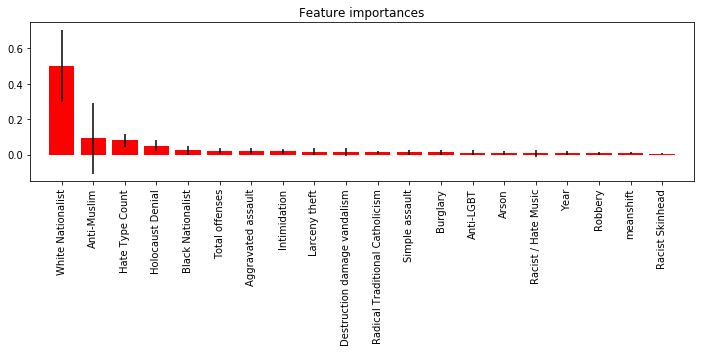

In [125]:
# Plot the feature importances of the forest
plt.figure(figsize=[10,5])
plt.title("Feature importances")
plt.bar(range(X_train_mo.iloc[:,:20].shape[1]), importances[indices[:20]],
       color="r", yerr=std[indices[:20]], align="center")
plt.xticks(range(X_train_mo.iloc[:,:20].shape[1]), name_of_cols[indices[:20]], rotation=90)
plt.xlim([-1, X_train_mo.iloc[:,:20].shape[1]])
plt.tight_layout()
plt.show()

New X with reduced number of features

In [131]:
X_reduced = X[name_of_cols[indices[:25]]]
Y_reduced = Y

In [132]:
X_reduced_train, X_reduced_test, y_reduced_train, y_reduced_test = train_test_split(
    X_reduced, Y_reduced, test_size=0.6, random_state=0)

In [134]:
rfr = ensemble.RandomForestRegressor(n_estimators=100, warm_start=True)

rfr.fit(X_reduced_train, y_reduced_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=True)

In [135]:
test_score_rfr_red = cross_val_score(rfr, X_reduced_test, y_reduced_test, cv=10)

print('Testing score: {} +/- {}'.format(np.mean(test_score_rfr_red),np.std(test_score_rfr_red)))

Testing score: 0.8137703866067423 +/- 0.07660248649055165


### KNN with multi output

Using the already scaled data, above

In [35]:

from sklearn.model_selection import GridSearchCV

from sklearn.neighbors import KNeighborsRegressor


In [36]:
# getting the best # for n
#knn = KNeighborsRegressor()

#params = {'n_neighbors':[2,3,4,5,6,7,8,9], 'weights': ['uniform', 'distance']}

#model = GridSearchCV(knn, params, cv=5)

In [37]:
#model.fit(x_train_scaled,y_train_mo)
#model.best_params_

{'n_neighbors': 4, 'weights': 'uniform'}

In [154]:
knn = KNeighborsRegressor(n_neighbors=4, weights='distance')

knn.fit(x_train_scaled,y_train_mo)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=4, p=2,
          weights='distance')

In [155]:
knn.score(x_test_scaled,y_test_mo)

0.7565863830606291

In [158]:
test_score_knn = cross_val_score(knn, x_test_scaled, y_test_mo, cv=10)

print('Testing score: {} +/- {}'.format(np.mean(test_score_knn),np.std(test_score_knn)))

Testing score: 0.727416931404309 +/- 0.08100246639514189


And using the reduced set of features:

In [150]:
scaler = MinMaxScaler(feature_range=(0, 1))

x_train_scaled_red = scaler.fit_transform(X_reduced_train)
x_test_scaled_red = scaler.fit_transform(X_reduced_test)

In [160]:
knn.fit(x_train_scaled_red, y_train_mo)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=4, p=2,
          weights='distance')

In [161]:
knn.score(x_test_scaled_red,y_test_mo)

0.8124033450868993

In [162]:
test_score_knn_red = cross_val_score(knn, x_test_scaled_red, y_test_mo, cv=10)

print('Testing score: {} +/- {}'.format(np.mean(test_score_knn_red),np.std(test_score_knn_red)))

Testing score: 0.7802680245839684 +/- 0.09177323537460573


### SVR with Multi Output

In [40]:
from sklearn.svm import SVR

from sklearn.multioutput import MultiOutputRegressor

svr_mor = MultiOutputRegressor(SVR())

svr_mor.fit(X_train_mo,y_train_mo)

MultiOutputRegressor(estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False),
           n_jobs=1)

In [41]:
svr_mor.score(X_test_mo,y_test_mo)

0.14192531524315163

In [42]:
test_score_svrm = cross_val_score(svr_mor, X_test_mo, y_test_mo, cv=10)

print('Testing score: {} +/- {}'.format(np.mean(test_score_svrm),np.std(test_score_svrm)))

Testing score: 0.09663074265068147 +/- 0.19981378962973403


With reduced set of features

In [165]:
svr_mor.fit(X_reduced_train,y_reduced_train)

MultiOutputRegressor(estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False),
           n_jobs=1)

In [166]:
test_score_svrm_r = cross_val_score(svr_mor, X_reduced_test, y_reduced_test, cv=10)

print('Testing score: {} +/- {}'.format(np.mean(test_score_svrm_r),np.std(test_score_svrm_r)))

Testing score: 0.0974992652780361 +/- 0.20501818665776214


## Gradient boosting

In [172]:
from sklearn.ensemble import GradientBoostingRegressor

In [176]:
# We'll make 500 iterations, use 2-deep trees, and set our loss function.
params = {'n_estimators': 500,
          'max_depth': 2}

clf = ensemble.GradientBoostingRegressor(**params)

clf_mor = MultiOutputRegressor(ensemble.GradientBoostingRegressor(**params))

clf_mor.fit(X_train_mo, y_train_mo)

MultiOutputRegressor(estimator=GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=2, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=500, presort='auto', random_state=None,
             subsample=1.0, verbose=0, warm_start=False),
           n_jobs=1)

In [177]:
clf_mor.score(X_test_mo,y_test_mo)

0.6596160064710846

In [178]:
test_score_clf = cross_val_score(clf_mor, X_test_mo, y_test_mo, cv=10)

print('Testing score: {} +/- {}'.format(np.mean(test_score_clf),np.std(test_score_clf)))


Testing score: 0.6455071721196338 +/- 0.0742358737679825


Reduced set of features

In [179]:
clf_mor.fit(X_reduced_train,y_reduced_train)

MultiOutputRegressor(estimator=GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=2, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=500, presort='auto', random_state=None,
             subsample=1.0, verbose=0, warm_start=False),
           n_jobs=1)

In [180]:
test_score_clf_r = cross_val_score(clf_mor, X_reduced_test, y_reduced_test, cv=10)

print('Testing score: {} +/- {}'.format(np.mean(test_score_clf_r),np.std(test_score_clf_r)))

Testing score: 0.6449350319654571 +/- 0.083983879200312


## Summary table

In [181]:
summary_models = pd.DataFrame(index= ['full - mean','full - std','reduced - mean', 'reduced - std'])

summary_models['Random forest'] = [np.mean(test_score_rfr_mo), np.std(test_score_rfr_mo),
                           np.mean(test_score_rfr_red), np.std(test_score_rfr_red)]

summary_models['KNN'] = [np.mean(test_score_knn), np.std(test_score_knn),
                           np.mean(test_score_knn_red), np.std(test_score_knn_red)]

summary_models['SVR'] = [np.mean(test_score_svrm), np.std(test_score_svrm),
                           np.mean(test_score_svrm_r), np.std(test_score_svrm_r)]

summary_models['Gradient boosting'] = [np.mean(test_score_clf), np.std(test_score_clf),
                           np.mean(test_score_clf_r), np.std(test_score_clf_r)]


In [182]:
summary_models

,Random forest,KNN,SVR,Gradient boosting
full - mean,0.792327,0.727417,0.096631,0.645507
full - std,0.076056,0.081002,0.199814,0.074236
reduced - mean,0.813770,0.780268,0.097499,0.644935
reduced - std,0.076602,0.091773,0.205018,0.083984
